In [1]:
import os,sys
import glob
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 
sns.set_style('darkgrid')
np.random.seed(2023)

In [2]:
# file path
dir_ = '/mnt/data1/jlk/Cmap_database/CLUE/'
cell_info_file = dir_ + "cellinfo_beta.txt"
gene_info_file = dir_ + 'geneinfo_beta.txt'
level5_info_file = dir_ + 'siginfo_beta.txt'
level3_info_file = dir_ + 'instinfo_beta.txt'
level3_save_dir = '{}/level3_cell_control'.format(dir_)
level4_save_dir = '{}/level4_cell_control'.format(dir_)
level5_save_dir = '{}/level5_cell_control'.format(dir_)

# use_cell_lines = ['MCF7','A375','PC3','HT29','A549','HA1E','NPC']
use_cell_lines = ['MCF7','A375','PC3','HT29','A549','HA1E']


In [3]:
##################
# cell demention data
##################

##### landmark gene
gene_df = pd.read_csv(gene_info_file,sep='\t')
print(gene_df['feature_space'].value_counts())
landmark_gene_df = gene_df[gene_df['feature_space']=='landmark']
landmark_gene_id = landmark_gene_df['gene_id']

##### cell info
level3_info_df = pd.read_csv(level3_info_file,sep='\t')
level3_info_df = level3_info_df[level3_info_df['pert_type'] == 'ctl_vehicle']
cell_types = level3_info_df['cell_iname'].value_counts()

def get_cell_data():
    y = []
    cell_type_label = 0
    for cell in use_cell_lines:
        cell_file = glob.glob('{}/{}*csv'.format(level3_save_dir,cell))[0]
        cell_df = pd.read_csv(cell_file)
        print(cell_file,cell_df.shape)

        cell_df = cell_df[cell_df['rid'].isin(landmark_gene_id)]
        cell_df = cell_df.sample(1000,axis=1,replace=True)
        
        cell_sig_data = cell_df.T.to_numpy()

        if cell_type_label == 0:
            all_cell_data = cell_sig_data
        else:
            all_cell_data = np.append(all_cell_data,cell_sig_data,axis=0)
        y += [cell]*cell_sig_data.shape[0]
        cell_type_label +=1
        print(cell_sig_data.shape,all_cell_data.shape,len(y))
    return all_cell_data,np.array(y)

cell_x,cell_y = get_cell_data()
X_tsne = TSNE(n_components=2, random_state=1).fit_transform(cell_x)
cell_demention_data = pd.DataFrame(X_tsne)
cell_demention_data.columns = ['x1','x2']
cell_demention_data['cell'] = cell_y

best inferred    9196
inferred         2154
landmark          978
Name: feature_space, dtype: int64


<ipython-input-3-7daaa1515464>:12: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  level3_info_df = pd.read_csv(level3_info_file,sep='\t')


/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/MCF7_10112.csv (12328, 10113)
(1000, 978) (1000, 978) 1000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/A375_6997.csv (12328, 6998)
(1000, 978) (2000, 978) 2000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/PC3_9178.csv (12328, 9179)
(1000, 978) (3000, 978) 3000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/HT29_6595.csv (12328, 6596)
(1000, 978) (4000, 978) 4000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/A549_8056.csv (12328, 8057)
(1000, 978) (5000, 978) 5000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/HA1E_5551.csv (12328, 5552)
(1000, 978) (6000, 978) 6000


In [4]:
##################
# cell coralation
##################
# cell_dict = dict(zip(range(len(use_cell_lines)),use_cell_lines))
df = pd.DataFrame(cell_x)
cell_rep_df = df.groupby(cell_y).mean()
cell_rep_df.index = use_cell_lines
cor_df = spearmanr(cell_rep_df.T)[0]
cor_df = pd.DataFrame(cor_df)
cor_df.index = use_cell_lines
cor_df.columns = use_cell_lines

In [5]:
##################
# cell accuacy data
##################

data_file = 'experiment_result.xlsx'
df = pd.read_excel(data_file,sheet_name='cell_lines',index_col=0)
methods = ['MOAEMB','DrSim','SigMat','RF',
           'GSEA','ssCmap','Xcosine','Xsum',
           'Euclidean','L1000CDS','Jaccard','Random']
methods_belong = {'MOAEMB':'MOAEMB','DrSim':'Machine learning','SigMat':'Machine learning','RF':'Machine learning',
           'GSEA':'Biology','ssCmap':'Biology','Xcosine':'Biology','Xsum':'Biology',
           'Euclidean':'Distance','L1000CDS':'Distance','Jaccard':'Distance','Random':'Random'}

cols = []
cols_kind = ['MOAEMB','Machine learning','Biology','Distance','Random']
col_pal = sns.color_palette("colorblind")
col_pal = sns.color_palette("deep", 10)
for method in methods:
    for i in range(len(cols_kind)):
        color = col_pal[i]
        kind = cols_kind[i]
        if methods_belong[method] == kind:
            cols.append(color)

df = df.loc[use_cell_lines]
cells = []
acc_sig = []
acc_val = []
tests = []
labels = []
folds = []
kinds = []
for method in methods:
    for fold in [0,1,2]:
        for cell in use_cell_lines:
            acc = df[df['Fold']==fold][method].values[0]
            acc_sig.append(acc)
            Test = df[df['Fold']==fold]['Test_sig'].values[0]
            tests.append(Test)
            acc_val.append(acc/Test)
            labels.append(method)
            folds.append(fold)
            kinds.append(methods_belong[method])
            cells.append(cell)
plot_df = pd.DataFrame()
# plot_df['test'] = tests
plot_df['method'] = labels
# plot_df['fold'] = folds
# plot_df['correct signatures'] = acc_sig
plot_df['accuracy'] = acc_val
# plot_df['kind'] = kinds
plot_df['cell'] = cells
print(plot_df)

     method  accuracy  cell
0    MOAEMB  0.597692  MCF7
1    MOAEMB  0.597692  A375
2    MOAEMB  0.597692   PC3
3    MOAEMB  0.597692  HT29
4    MOAEMB  0.597692  A549
..      ...       ...   ...
211  Random  0.061606  A375
212  Random  0.061606   PC3
213  Random  0.061606  HT29
214  Random  0.061606  A549
215  Random  0.061606  HA1E

[216 rows x 3 columns]


<ipython-input-8-bd8c533c077a>:7: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(data=cell_demention_data,x='x1',y='x2',hue='cell',


          MCF7      A375       PC3      HT29      A549      HA1E
MCF7  1.000000  0.878793  0.863084  0.834987  0.812736  0.854545
A375  0.878793  1.000000  0.858595  0.831639  0.844259  0.851999
PC3   0.863084  0.858595  1.000000  0.802380  0.796285  0.832325
HT29  0.834987  0.831639  0.802380  1.000000  0.832849  0.842984
A549  0.812736  0.844259  0.796285  0.832849  1.000000  0.819309
HA1E  0.854545  0.851999  0.832325  0.842984  0.819309  1.000000


<ipython-input-8-bd8c533c077a>:53: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


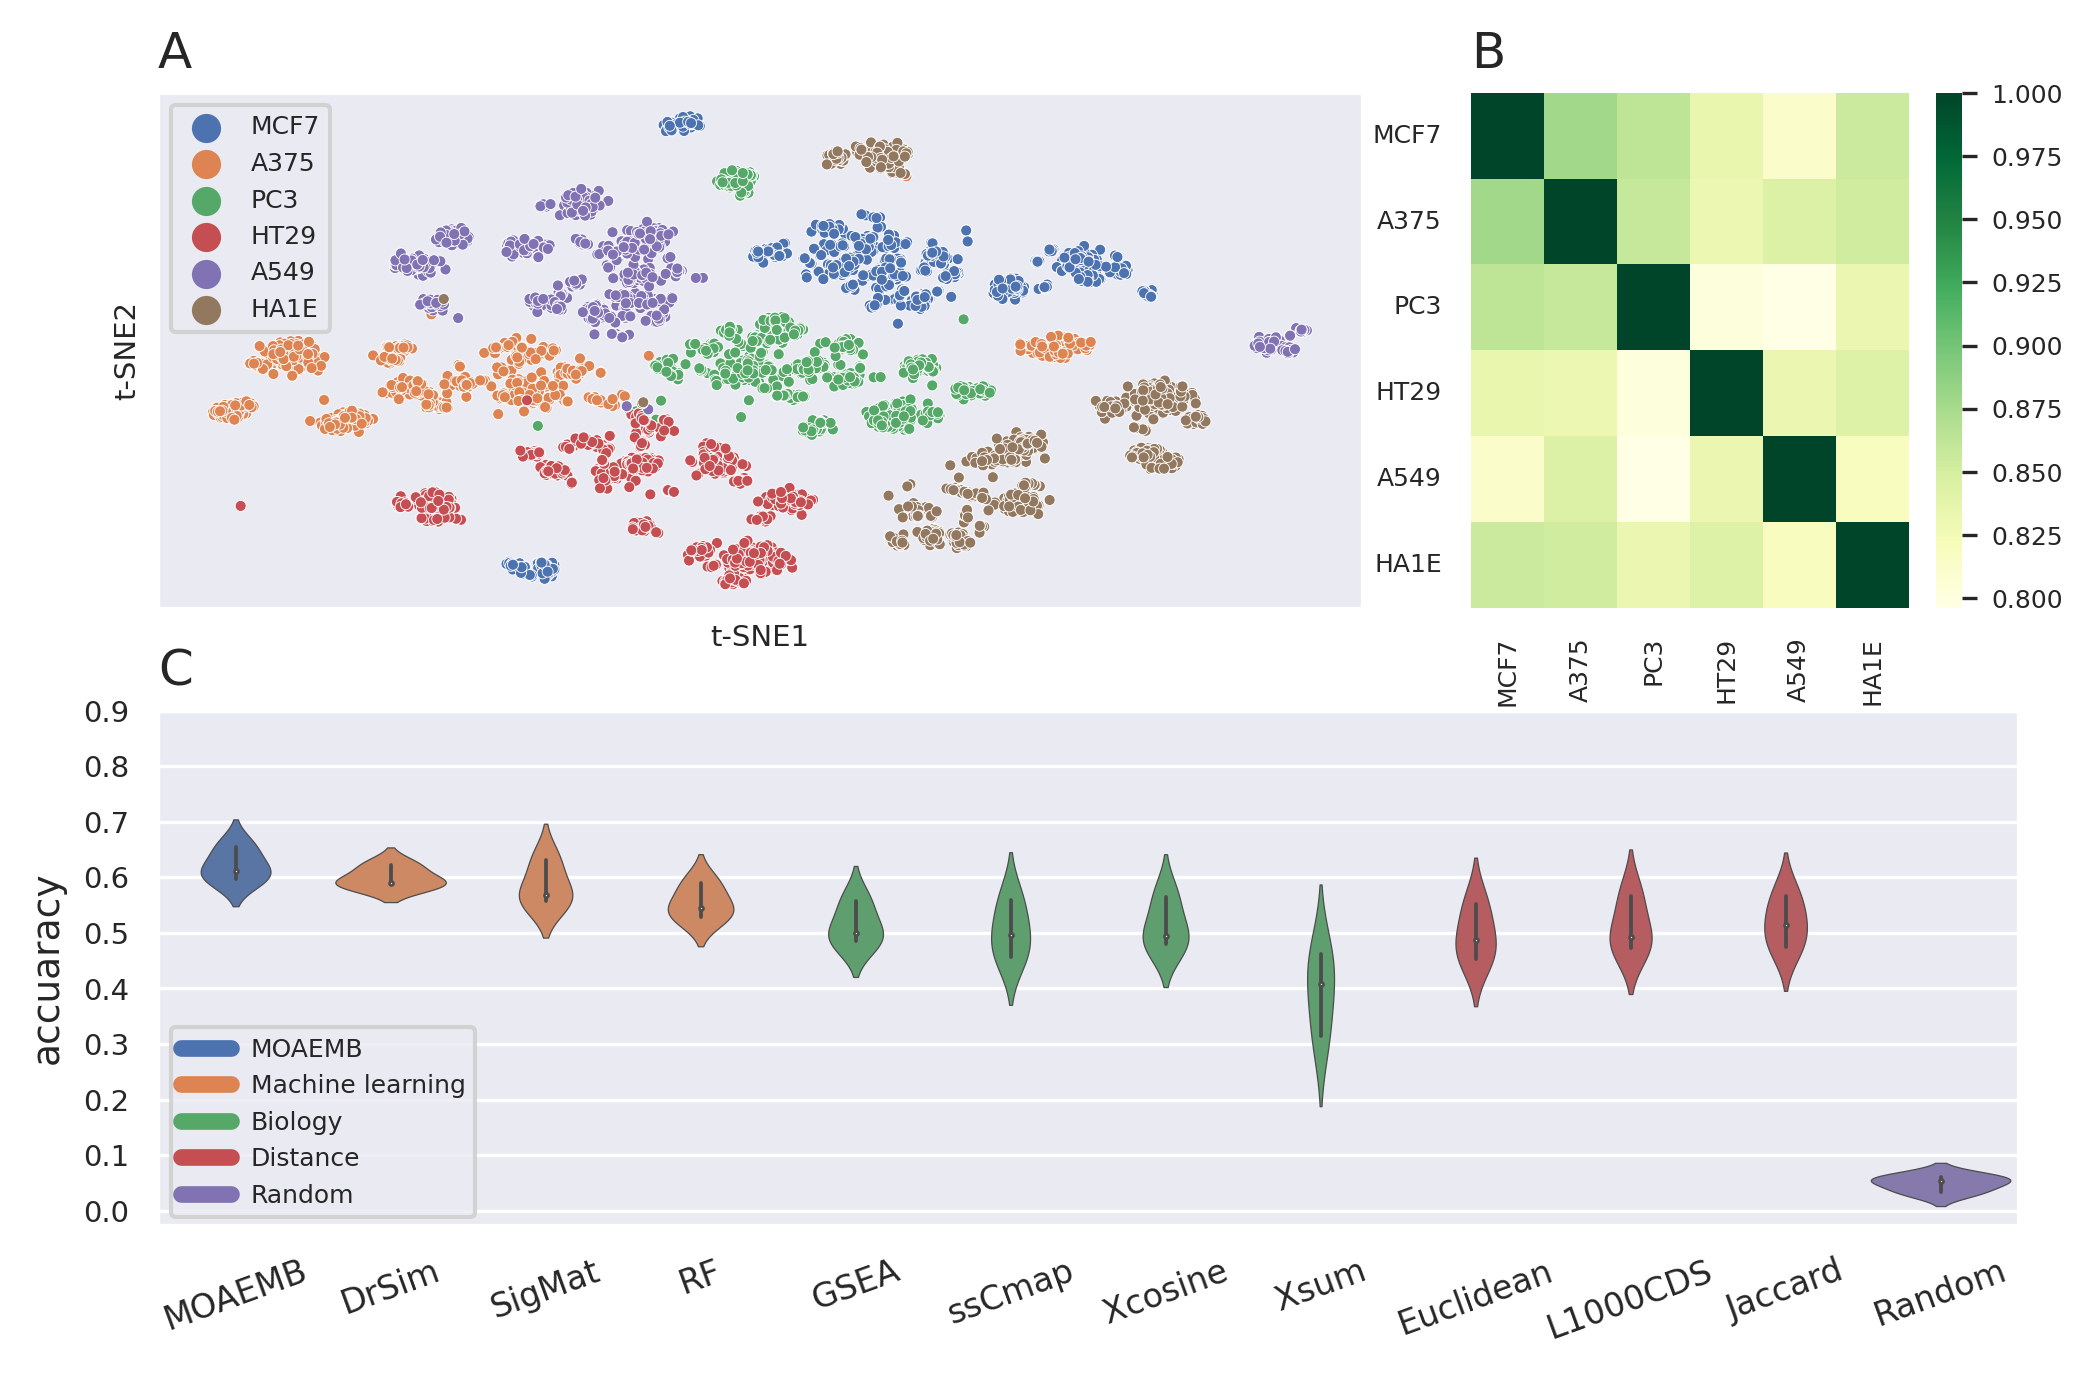

In [8]:
my_dpi=300
plt.figure(figsize=(8,5),dpi=my_dpi)

##################
# cell demention
ax1 = plt.subplot(2,3,(1,2))
sns.scatterplot(data=cell_demention_data,x='x1',y='x2',hue='cell',
                palette=sns.color_palette("deep", 10),ax=ax1,s=7)
# plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center left',fontsize=6)
plt.legend(fontsize=6)
plt.title('A',loc='left')

plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=7)
plt.ylabel('t-SNE2',fontsize=7)

##################
# cell distance
ax2 = plt.subplot(2,3,3)
cmap="YlGnBu"
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
cmap="YlGn"

cor_df=pd.read_csv('cor_df.csv',index_col=0)
print(cor_df)
sns.heatmap(cor_df,cmap=cmap,ax=ax2,)
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
# cor_df.to_csv('cor_df.csv')
plt.title('B',loc='left')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

##################
# accuracy
ax3 = plt.subplot(2,2,(3,4))
sns.violinplot(plot_df,x='method',y='accuracy',
               palette=cols,ax=ax3,bw=1,width=0.9,linewidth=.3).set(xlabel=None)
# sns.boxplot(plot_df,x='method',y='accuracy',
#                palette=cols,ax=ax3).set(xlabel=None)
custom_lines = [Line2D([0], [0], color=col_pal[0], lw=4),
                Line2D([0], [0], color=col_pal[1], lw=4),
                Line2D([0], [0], color=col_pal[2], lw=4),
                Line2D([0], [0], color=col_pal[3], lw=4),
                Line2D([0], [0], color=col_pal[4], lw=4)]
ax3.legend(custom_lines, cols_kind,bbox_to_anchor=(0, 0.2), loc='center left',fontsize=6)
plt.title('C',loc='left')
plt.xticks(rotation=20,fontsize=8)
plt.yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9],fontsize=7)
plt.ylabel('accuaracy',fontsize=9)

plt.tight_layout()
# plt.show()
plt.savefig('Figure4.jpg')